In [ ]:
!git clone https://github.com/1297rohit/RCNN.git

Cloning into 'RCNN'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 25 (delta 0), reused 1 (delta 0), pack-reused 22
Unpacking objects: 100% (25/25), done.


In [ ]:
cd RCNN

/content/RCNN


In [1]:
!pwd

/c/Users/DELL/Downloads/RCNN


In [ ]:
!unzip Images.zip

In [ ]:
!unzip Airplanes_Annotations.zip

In [2]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Using TensorFlow backend.
C:\Users\DELL\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\DELL\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\DELL\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\DELL\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

In [19]:
path = "C:/Users/DELL/Downloads/RCNN/Images/"
annot = "C:/Users/DELL/Downloads/RCNN/Airplanes_Annotations/"

42845.jpg


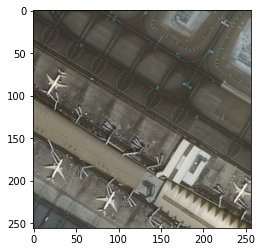

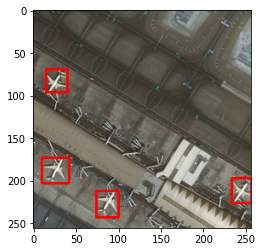

In [20]:
for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        break

In [21]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

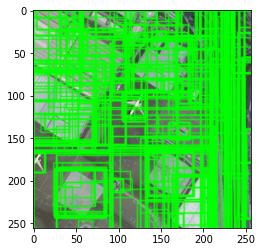

In [22]:
im = cv2.imread(os.path.join(path,"42850.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [23]:
train_images=[]
train_labels=[]

In [24]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [25]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [26]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue
    if e==5:
      break

In [ ]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [27]:
train_images

[]

In [ ]:
X_new.shape

(3947, 224, 224, 3)

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

#####imports#######

import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model
from keras.layers import *

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

input_tensor = Input(shape=(224, 224, 3))

In [ ]:
#vggmodel = VGG16(weights='imagenet', include_top=True)
#vggmodel.summary()

########## model intialising   ###########


model1 = VGG16(weights='imagenet', include_top=True, input_tensor=input_tensor)

model2 =keras.applications.VGG19(input_tensor=input_tensor, weights='imagenet', include_top=True)

model3 = keras.applications.MobileNet(input_tensor=input_tensor, include_top=True, weights="imagenet")


In [ ]:
#del model1, model2,model3

In [ ]:
##########  chanhing layer names ###########


for i in range (len(model1.layers)):
  model1.layers[i]._name = 'model1_'+ model1.layers[i]._name 

for i1 in range (len(model2.layers)):
  model2.layers[i1]._name = 'model2_'+ model2.layers[i1]._name 

for i2 in range (len(model3.layers)):
  model3.layers[i2]._name = 'model3_'+ model3.layers[i2]._name 

In [ ]:
len(model1.layers), len(model2.layers), len(model3.layers)

(23, 26, 92)

In [ ]:
for layers in (model1.layers)[:15]:
    layers.trainable = False

for layers in (model2.layers)[:18]:
    layers.trainable = False

for layers in (model3.layers)[:83]:
    layers.trainable = False

In [ ]:
#X= vggmodel.layers[-2].output

mergedOut = Concatenate()([model1.layers[-2].output, model2.layers[-2].output, model3.layers[-2].output])

In [ ]:
predictions = Dense(2, activation="softmax")(mergedOut)

In [ ]:
#model_final = Model(vggmodel.input,  predictions)
model_final = Model(inputs=[model1.input],outputs=[predictions])

In [ ]:
plot_model(model_final,to_file='demo.png',show_shapes=True)

In [ ]:
from keras.optimizers import Adam
opt = Adam(lr=0.0001)

In [ ]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [ ]:
model_final.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model3_model2_model1_input_1 (I [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model3_conv1 (Conv2D)           (None, 112, 112, 32) 864         model3_model2_model1_input_1[0][0
__________________________________________________________________________________________________
model3_conv1_bn (BatchNormaliza (None, 112, 112, 32) 128         model3_conv1[0][0]               
__________________________________________________________________________________________________
model3_conv1_relu (ReLU)        (None, 112, 112, 32) 0           model3_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
Y


3947

In [ ]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [ ]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(3552, 224, 224, 3) (395, 224, 224, 3) (3552, 2) (395, 2)


In [ ]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=30)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=30)
testdata = tsdata.flow(x=X_test, y=y_test)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [ ]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 5, validation_data= testdata, validation_steps=2)#, callbacks=[checkpoint,early])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
10/10 [==============================] - 6s 633ms/step - loss: 0.3491 - accuracy: 0.8813 - val_loss: 0.5199 - val_accuracy: 0.8281
Epoch 2/5
10/10 [==============================] - 6s 638ms/step - loss: 0.2866 - accuracy: 0.8875 - val_loss: 0.2698 - val_accuracy: 0.9219
Epoch 3/5
10/10 [==============================] - 6s 639ms/step - loss: 0.3175 - accuracy: 0.8906 - val_loss: 0.4990 - val_accuracy: 0.8438
Epoch 4/5
10/10 [==============================] - 7s 652ms/step - loss: 0.3221 - accuracy: 0.8844 - val_loss: 0.4811 - val_accuracy: 0.8281
Epoch 5/5
10/10 [==============================] - 7s 647ms/step - loss: 0.2971 - accuracy: 0.9062 - val_loss: 0.1838 - val_accuracy: 0.9375


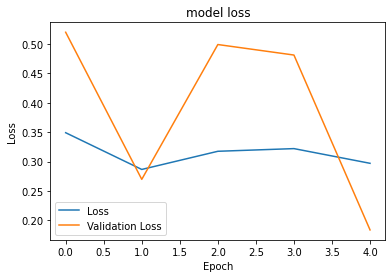

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

plane


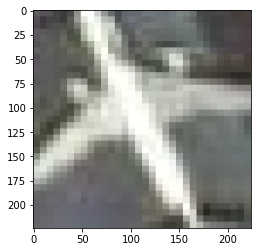

In [ ]:
im = X_test[16]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

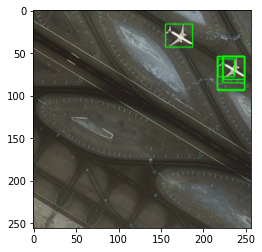

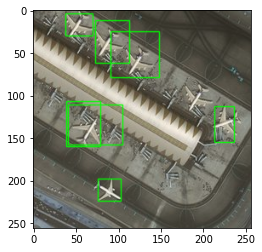

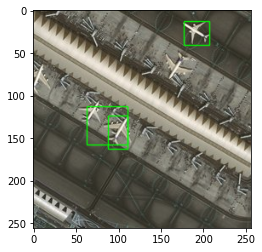

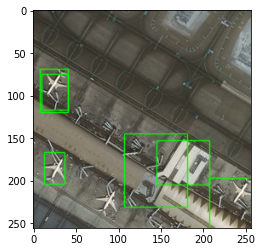

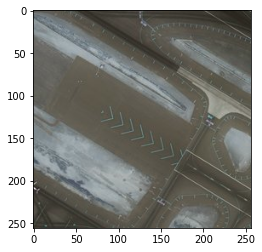

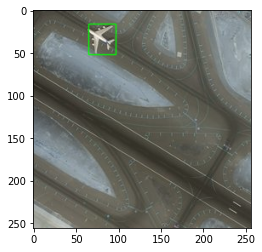

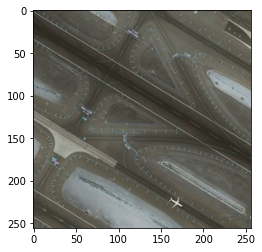

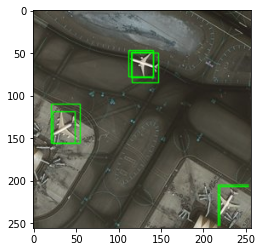

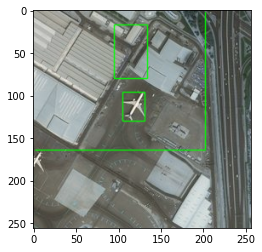

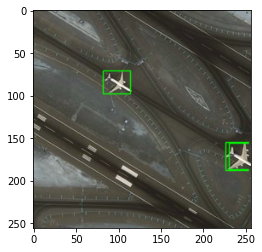

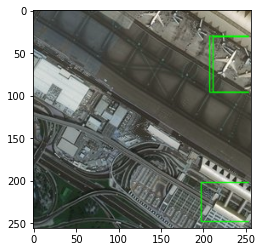

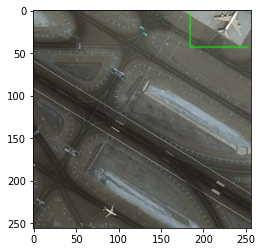

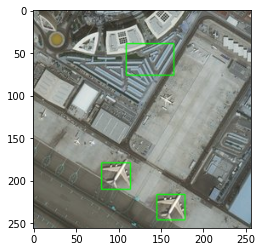

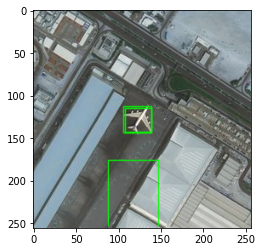

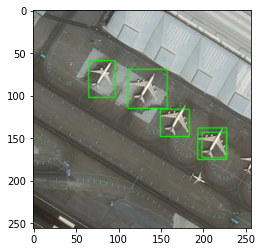

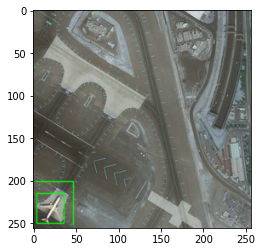

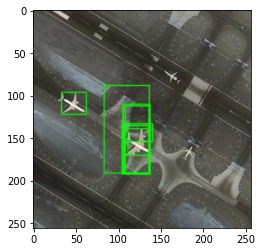

In [ ]:
z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.65:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)